##Download Dataset

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tungleduc","key":"c1abce0ca059f7413f6d058bc2ee0614"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                       title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023              Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           8499        331  1.0              
juhibhojani/house-price                                   House Price                                        7MB  2023-08-02 16:51:21            859         34  0.9411765        
arnavsmayan/netflix-userbase-dataset                      Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41          10081        180  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset  Cardiovascular Diseases Risk Prediction Dataset

In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1

100% 12.3G/12.3G [02:26<00:00, 168MB/s]
100% 12.3G/12.3G [02:27<00:00, 89.8MB/s]


In [ ]:
%%bash
mkdir ./kaggle
mkdir ./kaggle/Brats_2021/
unzip /content/brats-2021-task1.zip -d ./kaggle/Brats_2021/

Archive:  /content/brats-2021-task1.zip
  inflating: ./kaggle/Brats_2021/BraTS2021_00495.tar  
  inflating: ./kaggle/Brats_2021/BraTS2021_00621.tar  
  inflating: ./kaggle/Brats_2021/BraTS2021_Training_Data.tar  


In [ ]:
%%bash

pwd
cd kaggle/Brats_2021
pwd
ls
mkdir ./train
tar -xvf ./BraTS2021_Training_Data.tar -C ./train
rm ./BraTS2021_Training_Data.tar
mkdir ./test
tar -xvf ./BraTS2021_00495.tar -C ./test
rm ./BraTS2021_00495.tar

tar -xvf ./BraTS2021_00621.tar -C ./test
rm ./BraTS2021_00621.tar.tar

cd ../..

pwd

/content
/content/kaggle/Brats_2021
BraTS2021_00495.tar
BraTS2021_00621.tar
BraTS2021_Training_Data.tar
./
./.DS_Store
./BraTS2021_00000/
./BraTS2021_00000/BraTS2021_00000_flair.nii.gz
./BraTS2021_00000/BraTS2021_00000_seg.nii.gz
./BraTS2021_00000/BraTS2021_00000_t1.nii.gz
./BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz
./BraTS2021_00000/BraTS2021_00000_t2.nii.gz
./BraTS2021_00002/
./BraTS2021_00002/BraTS2021_00002_flair.nii.gz
./BraTS2021_00002/BraTS2021_00002_seg.nii.gz
./BraTS2021_00002/BraTS2021_00002_t1.nii.gz
./BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz
./BraTS2021_00002/BraTS2021_00002_t2.nii.gz
./BraTS2021_00003/
./BraTS2021_00003/BraTS2021_00003_flair.nii.gz
./BraTS2021_00003/BraTS2021_00003_seg.nii.gz
./BraTS2021_00003/BraTS2021_00003_t1.nii.gz
./BraTS2021_00003/BraTS2021_00003_t1ce.nii.gz
./BraTS2021_00003/BraTS2021_00003_t2.nii.gz
./BraTS2021_00005/
./BraTS2021_00005/BraTS2021_00005_flair.nii.gz
./BraTS2021_00005/BraTS2021_00005_seg.nii.gz
./BraTS2021_00005/BraTS2021_00005_t

In [ ]:
!pip install nibabel

rm: cannot remove './BraTS2021_00621.tar.tar': No such file or directory


### Test nibabel and view image shape

In [ ]:
import nibabel as nib
seg1_np = nib.load('/content/kaggle/Brats_2021/train/BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata()
print(seg1_np.shape)

(240, 240, 155)


In [ ]:
flair1_np = nib.load('/content/kaggle/Brats_2021/train/BraTS2021_00000/BraTS2021_00000_flair.nii.gz').get_fdata()

print(flair1_np.shape)



(240, 240, 155)


Text(0.5, 1.0, 'Flair Scan')

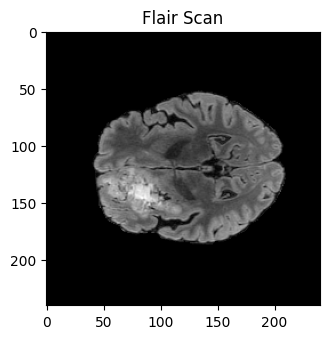

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(flair1_np[:, :, 70], cmap='gray')
plt.title('Flair Scan')


##Data Transformation

###Cut Image volume

#####fixed cut

In [ ]:
def fixed_cut_volume(img_np, begin_x_y =56,
                            end_x_y = 184,
                            begin_z = 13,
                            end_z = 141):
  return img_np[begin_x_y:end_x_y,begin_x_y:end_x_y,begin_z:end_z]


#### maximize seg cut


In [ ]:
from tensorflow import keras
import numpy as np
def adapt_cut_volume(image, label,
                   orig_x=240, orig_y = 240, orig_z=155,
                   output_x=128, output_y=128, output_z=128,
                   max_tries=1000,
                   background_threshold=0.95,
                   first_channel = True,
                   num_classes = 4):
    X, y = None, None

    tries = 0

    while tries < max_tries:

        start_x = np.random.randint(0, orig_x-output_x+1)
        start_y = np.random.randint(0, orig_y-output_y+1)
        start_z = np.random.randint(0, orig_z-output_z+1)

        y = label[start_x: start_x+output_x,
                  start_y: start_y+output_y,
                  start_z: start_z+output_z]

        y = keras.utils.to_categorical(y, num_classes= num_classes)

        bgrd_ratio = np.sum(y[:,:,:, 0]) / (output_x*output_y*output_z)

        tries += 1

        if bgrd_ratio < background_threshold:
            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z])

            if first_channel:
              X = np.moveaxis(X, -1, 0)

              y = np.moveaxis(y, -1, 0)



            return X, y

    print(f"Tried {tries} times to find a sub-volume. Giving up...")
    return None, None

def standardize(image):

    standardized_image = np.zeros(image.shape)

    for c in range(image.shape[0]):
        for z in range(image.shape[3]):

            image_slice = image[c,:,:,z]
            centered = image_slice - image_slice.mean()

            if np.std(centered) != 0:
                centered_scaled = centered / centered.std()

            standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

def fixed_cut_volume(img_np, begin_x_y =56,
                            end_x_y = 184,
                            begin_z = 13,
                            end_z = 141):
  return img_np[begin_x_y:end_x_y,begin_x_y:end_x_y,begin_z:end_z]

### Test cutting volume image

Text(0.5, 1.0, 'Flair Scan')

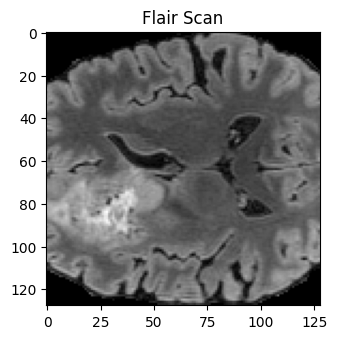

In [ ]:
import matplotlib.pyplot as plt
cut_vol = fixed_cut_volume(flair1_np)

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(cut_vol[:, :, np.random.randint(0,cut_vol.shape[2])], cmap='gray')
plt.title('Flair Scan')


4.0


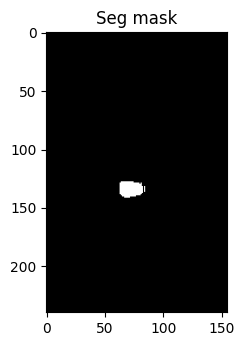

In [ ]:
a = np.swapaxes(seg1_np, 1,-1)
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(a[:, :,50], cmap='gray')
plt.title('Seg mask')
print(np.max(a[:, :,84]))

Text(0.5, 1.0, 'Seg mask')

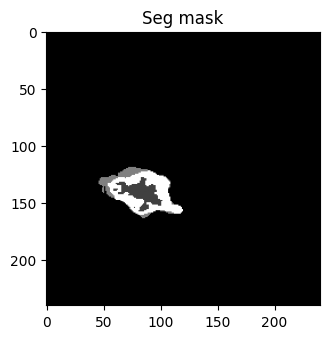

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(seg1_np[:, :, 70], cmap='gray')
plt.title('Seg mask')

### plot random mask

In [ ]:
def plot_analyze_mask(file_mask, slice_n, dim_cut = 2):

  mask_np = nib.load(file_mask).get_fdata()
  swap_np = np.swapaxes(mask_np, dim_cut, -1)

  print("slice stt: ", n_slice)
  print("Max=",np.max(seg1_np[:,:,slice_n]))
  print("Median=",np.median(seg1_np[:,:,slice_n]))

  plt.figure(figsize=(12, 8))
  plt.figure(figsize=(12,8))
  plt.subplot(231)
  plt.imshow(swap_np[:, :, slice_n], cmap='gray')
  plt.title('Mask:0 - Original')

  plt.figure(figsize=(12, 8))
  plt.figure(figsize=(12,8))
  plt.subplot(232)
  plt.imshow(swap_np[:, :, slice_n] == 0.0, cmap='gray')
  plt.title('Mask:0 - Background(white)')

  plt.figure(figsize=(12,8))
  plt.subplot(233)
  plt.imshow(swap_np[:, :, slice_n] == 1.0, cmap='gray')
  plt.title('Mask:1')

  plt.figure(figsize=(12,8))
  plt.subplot(234)
  plt.imshow(swap_np[:, :, slice_n] == 2.0, cmap='gray')
  plt.title('Mask:2')

  plt.figure(figsize=(12,8))
  plt.subplot(235)
  plt.imshow(swap_np[:, :, slice_n] == 3.0, cmap='gray')
  plt.title('Mask:3')

  plt.figure(figsize=(12,8))
  plt.subplot(236)
  plt.imshow(swap_np[:, :, slice_n] == 4.0, cmap='gray')
  plt.title('Mask:4')

51
slice stt:  51
Max= 4.0
Median= 0.0


<Figure size 1200x800 with 0 Axes>

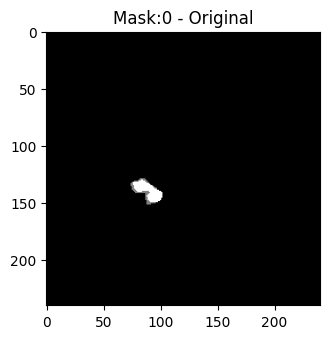

<Figure size 1200x800 with 0 Axes>

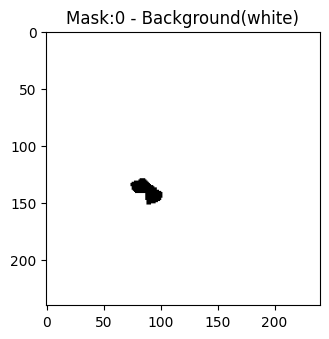

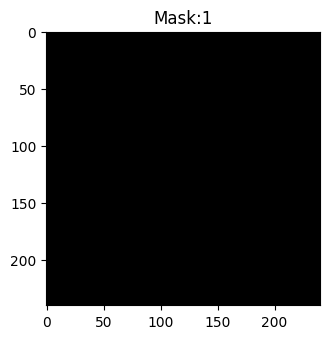

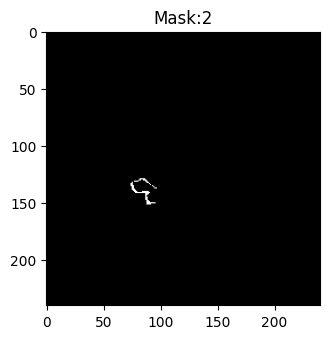

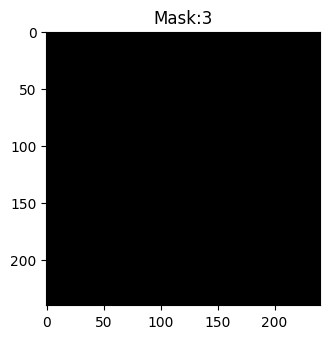

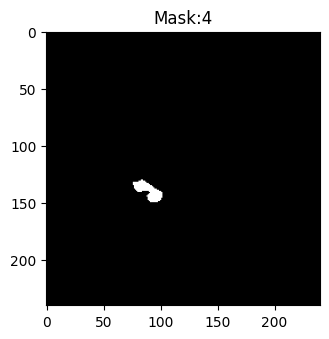

In [ ]:
sizes = {0:240, 1:240, 2:155}
test_111_path = '/content/kaggle/Brats_2021/train/BraTS2021_00000/BraTS2021_00000_seg.nii.gz'
n_slice = np.random.randint(13,sizes[2])
print(n_slice)
plot_analyze_mask(test_111_path, n_slice)

### extract data and convert to image album follow to image type

In [ ]:
import tensorflow as tf
import nibabel as nib
import glob
import numpy as np
import tarfile
import os
IMG_FEATURE_KEYS = ['flair', 't1', 't1ce', 't2']
MSK_FEATURE_KEY = 'mask'

_feature_spec = {
    **{key: tf.io.FixedLenFeature([], tf.string)
       for key in IMG_FEATURE_KEYS},
    'mask': tf.io.FixedLenFeature([], tf.string),
}

def extract_to_np_arr(data_dir):

    flair_f = glob.glob(data_dir + '*_flair.nii.gz')[0]
    t1_f = glob.glob(data_dir + f'*_t1.nii.gz')[0]
    t1ce_f = glob.glob(data_dir + f'*_t1ce.nii.gz')[0]
    t2_f = glob.glob(data_dir + f'*_t2.nii.gz')[0]
    msk_f = glob.glob(data_dir + f'*_seg.nii.gz')[0]

    flair_np = nib.load(flair_f).get_fdata()
    t1_np = nib.load(t1_f).get_fdata()
    t1ce_np = nib.load(t1ce_f).get_fdata()
    t2_np = nib.load(t2_f).get_fdata()
    msk_np = nib.load(msk_f).get_fdata()

    return {
        'flair': flair_np,
        't1': t1_np,
        't1ce': t1ce_np,
        't2': t2_np,
        'mask': msk_np
    }


def fn1_test():
    file_path = 'C:/Users/Admin/Desktop/DATN_20222/seg_prj/FinalProject/data/raw/BraTS2021_00621.tar'

    os.mkdir('BraTS2021_00621')
    dest_dir = './BraTS2021_00621'
    with tarfile(file_path) as tar_zef:
        tar_zef.extractall(dest_dir)

    img_dic = extract_to_np_arr(dest_dir)

    print(img_dic['flair'].shape)


In [ ]:
dic = extract_to_np_arr('/content/kaggle/Brats_2021/train/BraTS2021_00000/')

dic['flair'].shape

(240, 240, 155)

In [ ]:
H, W, D = 240, 240, 155
H_NEW, W_NEW, D_NEW = 128, 128, 128

### read and convert nib file to tfrecords

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.

  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def serialize_array(array):
    #print(array.shape)
    array = tf.io.serialize_tensor(array)
    #print(type(array))
    return array
def save_to_tfrecords_file(img_dic, writer,
                           is_cut = True):
    if is_cut:
      img_dic = {key: fixed_cut_volume(value) for key, value in img_dic.items()}
    feature = {
        **{
            key: _bytes_feature(serialize_array(value))
            for key, value in img_dic.items()
        },
    }
    # print(type(img_dic['flair']))
    # print(type(feature['flair']))
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    writer.write(example.SerializeToString())



####*Test* the function

In [ ]:
%%bash
mkdir test_fn
ls

brats-2021-task1.zip
kaggle
kaggle.json
sample_data
test_fn
utils


In [ ]:
name = 'BraTS2021_00000'
file_path = f'/content/test_fn/{name}.tfrecord'
with tf.io.TFRecordWriter(file_path) as writer:
  save_to_tfrecords_file(dic,writer)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### read tf record file and convert to tf dataset object

In [ ]:
IMG_FEATURE_KEYS = ['flair', 't1', 't1ce', 't2']
MSK_FEATURE_KEY = 'mask'
TOTAL_FEATURE_KEYS = IMG_FEATURE_KEYS.append(MSK_FEATURE_KEY)


_feature_spec = {
    **{key: tf.io.FixedLenFeature([], tf.string)
       for key in IMG_FEATURE_KEYS},
    'mask': tf.io.FixedLenFeature([], tf.string),
}

print(_feature_spec)

def change_type_and_shape(data_dic, has_cutting = True):
  for k in data_dic.keys():
    raw = data_dic[k]
    img_flatten = tf.io.parse_tensor(raw, out_type=tf.float64)
    if has_cutting:
      h,w,d = H_NEW, W_NEW, D_NEW
    else:
      h,w,d = H,W,D
    img = tf.reshape(img_flatten, shape=(h,w,d))
    data_dic[k] = img
  return data_dic
def _parse_image_function(example_proto):
    dataset = tf.io.parse_single_example(example_proto, _feature_spec)
    return dataset

def read_to_record_file(tf_record_file):
  raw_image_dataset = tf.data.TFRecordDataset(tf_record_file)
  parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

  fine_dataset = parsed_image_dataset.map(change_type_and_shape)

  return fine_dataset

{'flair': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 't1': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 't1ce': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 't2': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'mask': FixedLenFeature(shape=[], dtype=tf.string, default_value=None)}


(128, 128, 128)
0.0
514.0


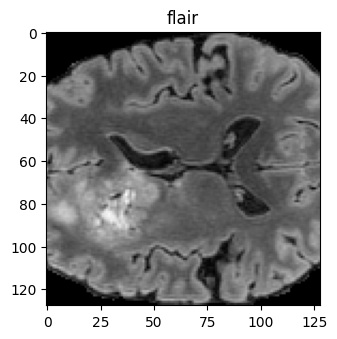

In [ ]:
record_file = '/content/test_fn/BraTS2021_00000.tfrecord'

test_dataset = read_to_record_file(record_file)

for example in test_dataset.take(1):
  print(example['flair'].numpy().shape)
  print(example['flair'][120][120][40].numpy())
  print(dic['flair'][120][120][40])

  plt.figure(figsize=(12,8))
  plt.subplot(231)
  plt.imshow(example['flair'][:, :, 70], cmap='gray')
  plt.title('flair')

###Save tfrecord recently created to gg drive


In [ ]:
import shutil

file_path_colab = '/content/test_fn/BraTS2021_00000.tfrecord'

folder_path_drive = '/content/drive/MyDrive/LGG_Dataset'

shutil.move(file_path_colab, folder_path_drive)

'/content/drive/MyDrive/LGG_Dataset/BraTS2021_00000.tfrecord'

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.imshow(seg1_np[:, :, 70+13], cmap='gray')
plt.title('Seg mask')

In [ ]:
!ls
RAW_SRC = '/content/kaggle/Brats_2021/train/'
print(glob.glob(RAW_SRC + '/BraTS2021_*').sort())
print(list(os.listdir(RAW_SRC)))

brats-2021-task1.zip  drive  kaggle  kaggle.json  sample_data  test_fn	utils
None
['BraTS2021_01483', 'BraTS2021_00441', 'BraTS2021_00667', 'BraTS2021_01256', 'BraTS2021_00765', 'BraTS2021_01362', 'BraTS2021_01001', 'BraTS2021_01331', 'BraTS2021_00551', 'BraTS2021_00563', 'BraTS2021_01128', 'BraTS2021_00352', 'BraTS2021_01212', 'BraTS2021_00002', 'BraTS2021_00579', 'BraTS2021_01629', 'BraTS2021_01247', 'BraTS2021_01105', 'BraTS2021_00304', 'BraTS2021_00297', 'BraTS2021_01296', 'BraTS2021_00046', 'BraTS2021_00620', 'BraTS2021_01500', 'BraTS2021_00107', 'BraTS2021_01335', 'BraTS2021_01307', 'BraTS2021_01593', 'BraTS2021_01588', 'BraTS2021_01394', 'BraTS2021_00402', 'BraTS2021_01364', 'BraTS2021_00317', 'BraTS2021_01080', 'BraTS2021_00104', 'BraTS2021_01561', 'BraTS2021_00470', 'BraTS2021_00089', 'BraTS2021_00210', 'BraTS2021_00006', 'BraTS2021_00587', 'BraTS2021_01520', 'BraTS2021_00134', 'BraTS2021_00526', 'BraTS2021_01261', 'BraTS2021_00260', 'BraTS2021_00478', 'BraTS2021_01567', 'BraT

In [ ]:
%%bash
cd /content/kaggle/Brats_2021/train


folder_path="/path/to/your/folder"


pattern="[0-9]$"


for file in "$folder_path"/*; do

    if [ -f "$file" ]; then

        echo "=== $file ==="

        grep -o "$pattern" "$file"
    fi
done


In [ ]:
def convert_all_niib_to_record(src_dir,dest_dir, name):
  folder_list = os.listdir(src_dir)
  file_path = dest_dir + name + '.tfrecord'

  with tf.io.TFRecordWriter(file_path) as writer:

    for fol in folder_list:
      folder = src_dir + fol + '/'
      dic = extract_to_np_arr(folder)
      save_to_tfrecords_file(dic,writer)

  return file_path


In [ ]:
!pip install ipywidgets

In [ ]:
def convert_partial_niib_to_tfrecord(src_dir, dest_dir,name, num_of_rc = 300, max_gb_size =12):
  folder_list = os.listdir(src_dir)
  if num_of_rc == -1:
    num_of_rc = len(folder_list)
  limit_rc = min(len(folder_list), num_of_rc)
  num_all_rc = len(folder_list)
  random_choices = np.random.choice(np.arange(0,num_all_rc), limit_rc, replace= False)
  file_path = dest_dir + name + f'_partial_{limit_rc}.tfrecord'
  folder_choices = [folder_list[k] for k in random_choices]

  if num_of_rc == -1:
    num_of_rc = len(folder_list)
  count = 0
  size_file = 0
  with tf.io.TFRecordWriter(file_path) as writer:
    while count < limit_rc and int(size_file) <= max_gb_size:

      folder = src_dir + folder_choices[count] + '/'
      dic = extract_to_np_arr(folder)
      save_to_tfrecords_file(dic,writer)

      if count % 10 == 0:
        file_size = os.path.getsize(file_path) / (1024**3)
        print('file size: ', file_size)
        print('count: ', count)

      count += 1
  if count < limit_rc:
    new_file_path = dest_dir + name + f'_partial_{count}.tfrecord'
    os.rename(file_path, new_file_path)
    file_path = new_file_path

  return count, file_path




In [ ]:
SRC_DIR = '/content/kaggle/Brats_2021/train/'
DST_DIR = '/content/extracted_data/'
ZIP_DIR = '/content/zip_data/'
TEST_DIR = '/content/kaggle/Brats_2021/test/'

In [ ]:
!mkdir extracted_data

In [ ]:
num_rc, file_path = convert_partial_niib_to_tfrecord(SRC_DIR, DST_DIR, 'brats_2021_train', num_of_rc=200)

!ls /content/extracted_data/



In [ ]:
print(f'Num of record in {file_path}: {num_rc}')

Num of record in /content/extracted_data/brats_2021_train_partial_200.tfrecord: 200


In [ ]:
!cp {file_path} /content/drive/MyDrive/LGG_Dataset/

In [ ]:
file_name = os.path.basename(file_path)

zip_file= file_name.replace('.tfrecord', '.zip')

print(zip_file)
print(file_path)

brats_2021_train_partial_200.zip
/content/extracted_data/brats_2021_train_partial_200.tfrecord


In [ ]:
%%bash
cd ./extracted_data
zip brats_2021_train_partial_300.zip brats_2021_train_partial_300.tfrecords


## Install and config google cloud

In [ ]:
!gcloud config set project "image-seg-project"

Updated property [core/project].


In [ ]:
!sudo pip3 install --no-cache-dir -U crcmod

In [ ]:
bucket_name = 'brats_img_300'
!gsutil cp /content/extracted_data/brats_2021_train_partial_300.tfrecords gs://{bucket_name}/

Copying file:///content/extracted_data/brats_2021_train_partial_300.tfrecords [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 401 Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not e

In [ ]:
!gsutil cp /content/extracted_data/brats_2021_test.tfrecords gs://{bucket_name}/

Copying file:///content/extracted_data/brats_2021_test.tfrecords [Content-Type=application/octet-stream]...
ServiceException: 401 Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not exist).


In [ ]:
!gcloud auth list


No credentialed accounts.

To login, run:
  $ gcloud auth login `ACCOUNT`



In [ ]:
!gcloud auth login elementalhero259@gmail.com


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=P8WQD9bzqD7R2AeDuIYyExkKWJbDI2&prompt=consent&access_type=offline&code_challenge=rqyzJvrC_SoIr67e8DtK2xJoeaHktU-dGU9-Nn7BeDY&code_challenge_method=S256

Enter authorization code: 4/0Adeu5BVHP6MYv_GcPrgZ077gwEeZ72lAdpUUbrsIJweDJZCvpIyLuklZdeFUx5ywG3KJ3Q

You are now logged in as [elementalhero259@gmail.com].
Your current project is [image-seg-project].  You can change this setting by running:
  $ gcloud config set proj

In [ ]:
!gcloud config list

[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
[core]
account = elementalhero259@gmail.com
project = image-seg-project

Your active configuration is: [default]


In [ ]:
!gsutil cp /content/extracted_data/brats_2021_test.tfrecords gs://{bucket_name}/

Copying file:///content/extracted_data/brats_2021_test.tfrecords [Content-Type=application/octet-stream]...
ServiceException: 401 Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not exist).


In [ ]:
!gcloud storage buckets list

---
creation_time: 2023-08-06T08:20:52+0000
default_storage_class: STANDARD
location: US
location_type: multi-region
metageneration: 1
name: brats_img_300
public_access_prevention: inherited
rpo: DEFAULT
storage_url: gs://brats_img_300/
uniform_bucket_level_access: true
update_time: 2023-08-06T08:20:52+0000


In [ ]:
!gcloud auth activate-service-account --help

In [ ]:
from google.colab import auth

# Xác thực và kết nối với tài khoản Google Cloud
auth.authenticate_user()


In [ ]:
import os

# Thiết lập biến môi trường cho gsutil
os.environ['CLOUDSDK_CONFIG'] = '/content/.config'


In [ ]:
!gsutil ls gs://[BUCKET_NAME]/


You are attempting to perform an operation that requires a project id, with none configured. Please re-run gsutil config and make sure to follow the instructions for finding and entering your default project id.


In [ ]:
!gcloud config set project img-seg-project

Are you sure you wish to set property [core/project] to img-seg-project?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [ ]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = elementalhero259@gmail.com
project = img-seg-project

Your active configuration is: [default]


In [ ]:
!gsutil cp /content/extracted_data/brats_2021_test.tfrecords gs://brats_img_300/

Copying file:///content/extracted_data/brats_2021_test.tfrecords [Content-Type=application/octet-stream]...
ServiceException: 401 Anonymous caller does not have storage.objects.create access to the Google Cloud Storage object. Permission 'storage.objects.create' denied on resource (or it may not exist).


## Image visualization

In [ ]:
import tensorflow as tf
from IPython.display import Image
from keras import backend as K
import imageio
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import cv2

In [ ]:
def plot_simple_2D_image(img):
  plt.figure(figsize=(12,8))
  plt.subplot(231)
  plt.imshow(img[:, :, 70], cmap='gray')
  plt.title('Image\Mask Scan')

In [ ]:
def plot_image_grid(image, remove_channel = None):
    data_all = []
    if remove_channel == None:
      remove_channel = np.random.randint(4)

    if remove_channel == 0:
      image = image[:,:,:,1:]
    elif remove_channel == 3:
      image = image[:,:,:,:-1]
    else:
      image = np.concatenate((image[:,:,:,:remove_channel],
                              image[:,:,:,remove_channel+1:]),
                             axis=-1)


    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
def visualize_data_gif(data_):
  images = []

  for i in range(data_.shape[0]):
    x = data_[min(i, data_.shape[0] - 1), :, :]
    y = data_[:, min(i, data_.shape[1]-1),:]
    z = data_[:, :, min(i, data_.shape[2] -1)]
    img = np.concatenate((x,y,z), axis=1)
    images.append(img)

  imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
  return Image(filename="/tmp/gif.gif", format='png')


In [ ]:
def visualize_patch(X, y):
  fig, ax = plt.subplots(1,2,figsize=[10,5], squaze=False)

  ax[0][0].imshow(X[:,:,0], cmap='Grey_r')
  ax[0][0].set_yticks([])
  ax[0][0].set_xticks([])
  ax[0][1].imshow(y[:,:,0], cmap='Greys_r')
  ax[1][0].set_xticks([])
  ax[0][1].set_yticks([])

  fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=5).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 3] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image

In [ ]:
def predict_and_viz(image, label, model, threshold, loc=(100,100,50)):
  image_labeled = get_labeled_image(image.copy(), label.copy())

  model_label = np.zeros([3,320,320,160])

  for x in range(0, image.shape[0], 160):
    for y in range(0, image.shape[1], 160):
      for z in range(0, image.shape[2], 160):
        patch = np.zeros([4,160,160,16])
        p = np.moveaxis(image[x: x +160, y:y + 160, z:z +16], 3, 0)
        patch[:, 0:p.shape[1], 0:p.shape[2], 0:p.shape[3]] = p
        pred = model.predict(np.expand_dims(patch, 0))
        model_label[:, x:x + p.shape[1],
                    y:y + p.shape[2],
                    z:z + p.shape[3]] += pred[0][:,:p.shape[1], :p.shape[2],
                                                 :p.shape[3]]

  model_label = np.moveaxis(model_label[:, 0:240, 0:240, 0:155], 0, 3)

  model_label_reformatted = np.zeros(240, 240, 155, 4)

  model_label_reformatted[:, :, :, 1:4] = to_categorical(label, num_classes=4).astype(np.uint8)

  model_label_reformatted[:, :, :, 1:4] = model_label

  model_label_reformatted[:,:,:,1:4] = model_label

  model_labeled_image = get_labeled_image(image, model_label_reformatted,
                                        is_categorical=True)

  fig, ax = plt.subplot(2,3, figsize=[10,7])

  x,y,z = loc

  ax[0][0].imshow(np.rot90(image_labeled[x, :, :, :]))
  ax[0][0].set_ylabel('Grouth Truth', fontsize=15)
  ax[0][0].set_xlabel('Sagital', fontsize=15)

  ax[0][1].imshow(np.rot90(image_labeled[:, y, :, :]))
  ax[0][1].set_xlabel('Coronal', fontsize=15)

  ax[0][2].imshow(np.squeeze(image_labeled[:, :, z, :]))
  ax[0][2].set_xlabel('Tranversal', fontsize=15)

  ax[1][0].imshow(np.rot90(model_labeled_image[x, :, :, :]))
  ax[1][0].set_ylabel('Prediction', fontsize=15)

  ax[1][1].imshow(np.rot90(model_labeled_image[:,y,:,:]))
  ax[1][2].imshow(model_labeled_image[:,:,z,:])

  fig.subplot_adjust(wspace=0, hspace=.12)

  for i in range(2):
    for j in range(3):
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])

  return model_label_reformatted




### Test Image Visualization

In [ ]:
viz_test_dir = '/content/kaggle/Brats_2021/train/BraTS2021_00000/'
viz_img_dic = extract_to_np_arr(viz_test_dir)
print(viz_img_dic.keys())

dict_keys(['flair', 't1', 't1ce', 't2', 'mask'])


In [ ]:
y_viz = viz_img_dic.pop('mask')
print(y_viz.shape)
print(np.max(y_viz))

(240, 240, 155)
4.0


In [ ]:
viz_img_dic.pop('t1ce')
X_viz = np.moveaxis(np.stack(list(viz_img_dic.values())),0,-1)

print(X_viz.shape)

(240, 240, 155, 3)


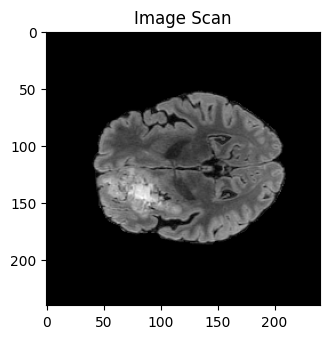

In [ ]:
plot_simple_2D_image(X_viz[:,:,:,0])

In [ ]:
X_array = list(viz_img_dic.values())

print(type(X_array[0]))

<class 'numpy.ndarray'>


In [ ]:
print(np.max(X_viz))

2934.0


(240, 240, 155, 4)


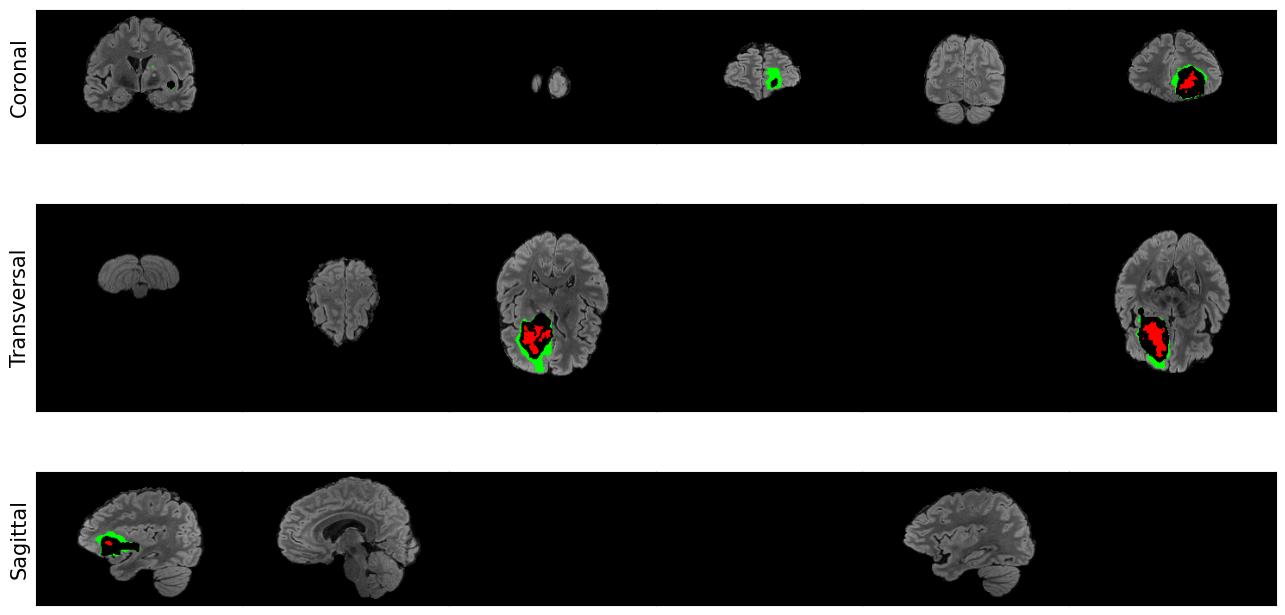

In [ ]:
image_viz = get_labeled_image(X_viz, y_viz)
print(image_viz.shape)
plot_image_grid(image_viz, remove_channel=3)

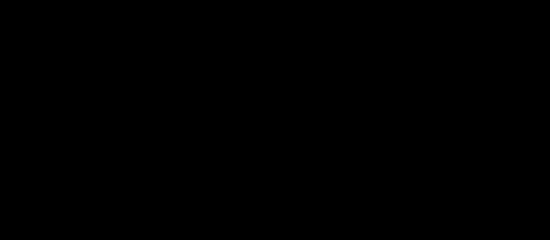

In [ ]:
visualize_data_gif(image_viz)

## Data Augmentation


In [ ]:
!pip install elasticdeform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from scipy.ndimage.interpolation import affine_transform
import elasticdeform
import multiprocessing as mp
from scipy.ndimage import shift
from skimage.transform import swirl
import random
from scipy.stats import truncnorm
import matplotlib.pyplot as plt


<ipython-input-67-7c0c3dc3aad1>:2: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import affine_transform


In [ ]:
def tumor_removement(X, y):
    for channel in range(X.shape[-1]):
        X[:, :, :, channel][y != 0] = 0
    y[y != 0] = 0
    return X, y

In [ ]:
def shift3D(X, y, shift_stds=[20,20,20]):

  shifts = [truncnorm.rvs(-1,1, loc=0, scale=std, size=1) for std in shift_stds]

  X_shft = np.empty_like(X)

  for channel in range(X.shape[-1]):
    X_shft[:,:,:,channel] = shift(X[:,:,:,channel], shifts, order=3)

  y_shft = shift(y, shifts, order=0)

  return X_shft, y_shft

In [ ]:
def swirl3D(X, y, radius=100, strength_std=1):
  AXES = [(0,1), (1,2), (0,2)]
  ax1, ax2 = random.choices(AXES)
  strength = truncnorm.rvs(-1, 1, loc=0, scale=strength_std, size=1)

  X_swapped = np.swapaxes(X, ax1, ax2)

  for channel in range(X.shape[-1]):
    X_swapped[:,:,:,channel] = swirl(
     X_swapped[:,:,:, channel],
     rotation = 0,
     strength=strength,
     radius=radius,
     order=3,
    )

  X_swapped = np.swapaxes(X_swapped, ax1, ax2)

  y_swapped = np.swapaxes(y, ax1, ax2)
  y_swapped = swirl(y_swapped, rotation=0, strength=strength, radius=radius, order=0)
  y_swapped = np.swapaxes(y_swapped, ax1, ax2)

  return X_swapped, y_swapped



In [ ]:
def one_class_flip(X, y):
  choice = np.random.randint(3)
  label = np.random.randint(low=1, high=4)

  X_flip = np.empty_like(X)
  y_flip = np.empty_like(y)

  for channel in range(X.shape[-1]):
    if choice == 0:
      y_flip = np.where(y == label, y[::-1, :, :], y)
    if choice == 1:
      y_flip = np.where(y == label, y[:,::-1, :], y)
    if choice == 2:
      y_flip = np.where(y == label, y[:,:,::-1], y)

    return X_flip, y_flip



In [ ]:
def flip3D(X, y):

  choice = np.random.randint(3)

  if choice == 0:
    X_flip, y_flip = X[::-1,:,:], y[::-1, :, :]
  if choice == 1:
    X_flip, y_flip = X[:,::-1, :, :], y[:,::-1, :]
  if choice == 2:
    X_flip, y_flip = X[:, :, ::-1, :], y[:,:,::-1]

  return X_flip, y_flip

In [ ]:
def rotation3D(X, y):
  alpha, beta, gamma = (
      np.pi
      * np.random.random_sample(
          3,
      )
      /2
  )

  Rx = np.array(
      [
          [1,0,0],
          [0, np.cos(alpha), -np.sin(alpha)],
          [0, np.sin(alpha), np.cos(alpha)],
      ]
  )

  Ry = np.array(
      [
         [np.cos(beta), 0, np.sin(beta)],
         [0,1,0],
         [-np.sin(beta), 0, np.cos(beta)]
      ]
  )

  Rz = np.array(
      [
          [np.cos(gamma), -np.sin(gamma), 0],
          [np.sin(gamma), np.cos(gamma), 0],
          [0,0,1],
      ]
  )

  R = np.dot(np.dot(Rx, Ry), Rz)

  X_rot = np.dot(np.dot(Rx,Ry), Rz)

  X_rot = np.empty_like(X)

  for channel in range(X.shape[-1]):
    X_rot[:,:,:,channel] = affine_transform(
        X[:,:,:,channel], R, offset = 0, order=3, mode="constant"
    )

  y_rot = affine_transform(y, R, offset=0, order=3, mode="constant")

  return X_rot, y_rot





In [ ]:
def brightness(X, y):
  X_new = np.zeros(X.shape)
  for c in range(X.shape[-1]):
    im = X[:, :, :, c]
    gain, gamma = (1.2 - 0.8) * np.random.random_sample(
        2,
    )+ 0.8
    im_new = np.sign(im) * gain * (np.abs(im) ** gamma)
    X_new[:, :, :, c] = im_new

  return X_new, y


In [ ]:
def elastic(X, y):
  [Xel, yel] = elasticdeform.deform_random_grid(
      [X,y], sigma=2, axis=[(0,1,2), (0,1,2)], order=[1,0], mode="constant"
  )

  return Xel, yel

In [ ]:
def random_decision(N, n_aug_techs=6):

  decisions = np.zeros(
      N
  )
  for n in range(N):
    decisions[n] = np.random.randint(n_aug_techs)

  return decisions


In [ ]:
def combine_aug(X, y, do):
  Xnew, ynew = X, y

  if np.random.random_sample() > 0.5:
    return Xnew, ynew

  else:
    if do == 0:
      Xnew, ynew = flip3D(Xnew, ynew)
    elif do == 1:
      Xnew, ynew = brightness(Xnew, ynew)
    elif do == 2:
      Xnew, ynew = rotation3D(Xnew, ynew)
    elif do == 3:
      Xnew, ynew = elastic(Xnew, ynew)
    elif do == 4:
      Xnew, ynew = shift3D(Xnew, ynew)
    elif do == 5:
      Xnew, ynew = swirl3D(Xnew, ynew)

    return Xnew, ynew

###Test augment function

In [ ]:
aug_test_dir = '/content/kaggle/Brats_2021/train/BraTS2021_00000/'
aug_img_dic = extract_to_np_arr(aug_test_dir)
print(aug_img_dic.keys())

dict_keys(['flair', 't1', 't1ce', 't2', 'mask'])


In [ ]:
y_aug = aug_img_dic.pop('mask')
x_remove = aug_img_dic.pop('t2')
X_aug = np.moveaxis(np.stack(list(aug_img_dic.values())),0,-1)

#### test remove tumor

In [ ]:
#test remove turmor
X_rm_tumor, y_rm_tumor = tumor_removement(X_aug, y_aug)

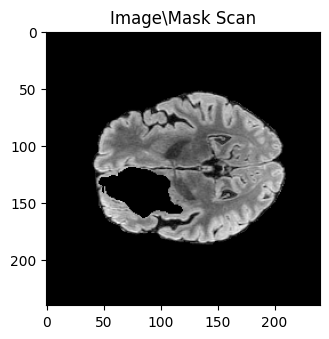

In [ ]:
plot_simple_2D_image(X_rm_tumor[:,:,:,0])

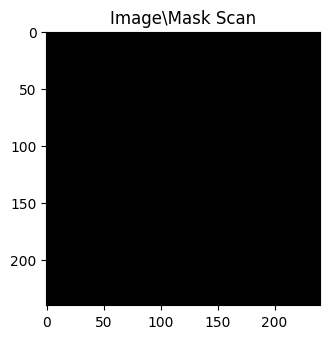

In [ ]:
plot_simple_2D_image(y_rm_tumor)

#### test shift 3D

In [ ]:
X_shift_3d, y_shift_3d = shift3D(X_aug, y_aug)

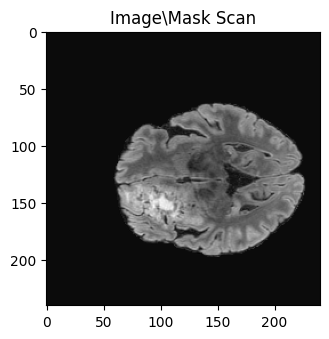

In [ ]:
plot_simple_2D_image(X_shift_3d[:,:,:,0])

In [ ]:
print(y_shift_3d.shape)

(240, 240, 155)


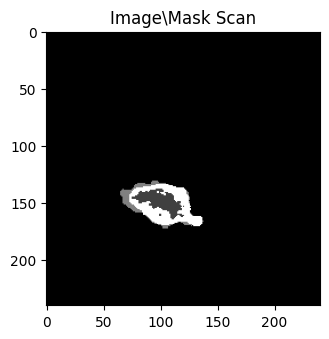

In [ ]:
plot_simple_2D_image(y_shift_3d[:,:,:])

###Install Tensorflow Extend

In [ ]:
%%shell
sudo apt update
sudo apt install python3.8 python3.8-distutils python3.8-dev
update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 3
curl -O https://bootstrap.pypa.io/get-pip.py
python get-pip.py

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [43.3 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [456 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com

In [ ]:
!grep -v google-auth /etc/requirements.core.in > requirements.txt

In [ ]:
!grep httplib2 /etc/requirements.user.in >> requirements.txt

In [ ]:
!mkdir /usr/local/lib/python3.8/dist-packages/google
!ln -s /usr/local/lib/python3.10/dist-packages/google/colab /usr/local/lib/python3.8/dist-packages/google/colab

In [ ]:
!pip install tfx==1.13.0 -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.8/426.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Create Example Gen Component

In [ ]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

from tfx import v1 as tfx

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel

from google.protobuf.json_format import MessageToDict

print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.12.1
TFX version: 1.13.0


In [ ]:
# Location of the pipeline metadata store
_pipeline_root = './pipeline/'

# Data files directory
_data_root = './extracted_data/'

# Path to the training data
_data_filepath = os.path.join(_data_root, 'brats_2021_train_partial_200.tfrecord')

In [ ]:
context = InteractiveContext(pipeline_root=_pipeline_root)

In [ ]:
# Ingest the data through ExampleGen
example_gen = tfx.components.ImportExampleGen(input_base=_data_root)

# Run the component
context.run(example_gen)

ValueError: ignored